# Data Analysis Using LLM's
### How this tool works: -
1. Sending comments in batches of 2000 to gpt-4's 128k model to get initial topics which the comments are divided into  
2. The summaries for these batches are then consolidated into one JSON file with details that include comment themes, percentage of the theme present in the data, number of positive and negative comments for each topic
3. Save the generated JSON file which we can use for future comparisons
4. Using the data generated we plot 2 graphs; 1. where the percentage of themes is plotted. 2. The number of positive and negative comments for each topic.
5. The images of the plots are saved
6. Finally, we can ask specific question to the data using PandasAI (Eg. How many customers in the survey speak French?)

## Setting up Azure LLM
We use gpt-4-1106-preview with 128k tokens as context

In [2]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
import csv

load_dotenv()


#AzureOpenAI setup
client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    # api_type='azure',
    api_version='2023-05-15',  # this may change in the future
    timeout=20*60,  # 20 minutes
)

#To generate summaries from 1000's of comments
def generate_summary(prompt):
    response = client.chat.completions.create(
        temperature=0.0,
        model="gpt-4-1106-preview",
        messages=[
                {"role": "system", "content":"""You are a product manager.
                """},
                {"role": "user", "content": prompt },
            ]
    )

    return response.choices[0].message.content


#To consolidate different Summaries (The prompt "Business Analyst" makes summaries more concise and to the point.)
def consolidate_summaries(prompt):
    response = client.chat.completions.create(
    temperature=0.0,
    model="gpt-4-1106-preview",
    messages=[
            {"role": "system", "content":"""You are a Business Analyst.
            """},
            {"role": "user", "content": prompt },
        ]
    )
    return response.choices[0].message.content



## Reading from the csv
We can change the name of the CSV and the column name that we want to analyse over here.

In [3]:
column_name = "Q2 - Comment - Recommendations"  #We can extract the column we want to analyse by providing the appropriate name.
with open("survey.csv", 'r', newline='') as csvfile: #We can the input file here.
    reader = csv.DictReader(csvfile)
    if column_name not in reader.fieldnames:
        print("Field name not found!")
    column_data = [row[column_name] for row in reader if row[column_name].strip()]

print(f"Number of comments in the column: {len(column_data)}")

#Making batches of 2000 comments
batch_size = 2000 #We can change the number of comments in each batch, depending on the survey type.
total_batches = (len(column_data) + batch_size - 1)//batch_size
print(f"Number of batches: {total_batches}")


Number of comments in the column: 7044
Number of batches: 4


## Analyzing comments in batches to establish Themes

In [4]:
appended_responses = []

for batch_number in range(total_batches):
    start_index = batch_number * batch_size
    end_index = (batch_number + 1) * batch_size
    comment_batch = column_data[start_index:end_index]
    prompt = """As a poduct manager, analyze if the comments seperated by a single quotes are positive or negative and give the weight by occurence of each topic % 
    give a summary in the following JSON format.
        {
    "date": "Todays_Date",
    "theme_weights": {
        "Theme 1": [{theme1_percentage}%, number of positive comments, number of negative comments],",
        "Theme 2": [{theme2_percentage}%, number of positive comments, number of negative comments]%",
        "Theme 3": [{theme3_percentage}%, number of positive comments, number of negative comments]%
    }
    "Summary": "Consolidated Summary of all the comments"
    }
    comments:""" + f"```{comment_batch}```"
    summary = generate_summary(prompt)
    print(f"######Summary of batch number {batch_number}: -")
    print(summary)
    appended_responses.append(summary)

######Summary of batch number 0: -
Based on the provided comments, I have analyzed the sentiment and categorized them into themes. Here is the summary in the requested JSON format:

```json
{
    "date": "2023-04-14",
    "theme_weights": {
        "Call Quality": [15%, 20 positive comments, 35 negative comments],
        "Customer Service": [20%, 25 positive comments, 45 negative comments],
        "App Functionality": [10%, 15 positive comments, 15 negative comments],
        "Billing Issues": [5%, 5 positive comments, 10 negative comments],
        "Ease of Use": [10%, 20 positive comments, 10 negative comments],
        "Technical Support": [15%, 10 positive comments, 35 negative comments],
        "Product Features": [10%, 15 positive comments, 15 negative comments],
        "System Reliability": [10%, 10 positive comments, 20 negative comments],
        "Onboarding Experience": [5%, 5 positive comments, 10 negative comments]
    },
    "Summary": "Overall, the sentiment towards t

## Consolidating different responses recieved from the LLM

In [6]:
prompt3 = """
As a business Analyst, 
analyze the following summaries seperated by single quotes and give the consolidated weight by occurence percentage(%), number of positive comments and number of negative commenst for every theme along with a comprehensive summary,
Generate a JSON file in the following format:

{
  "date": "Todays_Date",
  "theme_weights": {
      "Theme 1": [{theme1_percentage}%, {number of positive comments}, {number of negative comments}],",
      "Theme 2": [{theme2_percentage}%, {number of positive comments}, {number of negative comments}]",
      "Theme 3": [{theme3_percentage}%, {number of positive comments}, {number of negative comments}]
  }
  "Summary": "Consolidated Summary of all the comments"
}
""" + f"Seperate Summaries:```{appended_responses}```"

#Comparing the summaries and generating a final summary
final_analysis = consolidate_summaries(prompt3)
print(final_analysis)

To consolidate the provided summaries, we need to combine the themes and calculate the overall weight by occurrence percentage, the number of positive comments, and the number of negative comments for each theme. We also need to create a comprehensive summary of all the comments.

First, let's identify the unique themes across all summaries:
1. Call Quality
2. Customer Service
3. App Functionality
4. Billing Issues
5. Ease of Use
6. Technical Support
7. Product Features
8. System Reliability
9. Onboarding Experience
10. Integration with Other Tools
11. Flexibility and Remote Work Capability
12. Pricing and Value
13. System Complexity and User-Friendliness
14. Convenience and Usability
15. App Performance
16. Integration and Features
17. Reliability
18. Billing and Account Management
19. Overall Satisfaction
20. System Usability

Next, we will calculate the consolidated weight by occurrence percentage, the number of positive comments, and the number of negative comments for each theme. 

## Extracting the JSON file containing Main Topics with +ve & -ve comments 
It is saved as "analysis_<todays_date>.json"

In [7]:
import json
from datetime import date

start_index = final_analysis.find('{')
end_index = final_analysis.rfind('}')

if start_index != -1 and end_index != -1:
    json_part = final_analysis[start_index:end_index+1]
    print(json_part)
    try:
        # Load the JSON part using a JSON parser
        json_data = json.loads(json_part)
        json_data["date"] = str(date.today()) #GPT can't get dates right :(
        print("Extracted JSON:", json_data)
        file_path = f"analysis_{str(date.today())}.json"
        with open(file_path, 'w') as json_file:
            json.dump(json_data, json_file, indent=4)
    except json.JSONDecodeError:
        print("Invalid JSON structure.")

        

{
  "date": "2023-04-14",
  "theme_weights": {
    "Call Quality": ["22.5%", 56, 124],
    "Customer Service": ["27.5%", 63, 107],
    "App Functionality": ["10%", 15, 15],
    "Billing Issues": ["5%", 6, 25],
    "Ease of Use": ["10%", 20, 10],
    "Technical Support": ["15%", 10, 35],
    "Product Features": ["10%", 15, 15],
    "System Reliability": ["10%", 10, 20],
    "Onboarding Experience": ["5%", 8, 22],
    "Integration with Other Tools": ["5%", 4, 11],
    "Flexibility and Remote Work Capability": ["10%", 15, 5],
    "Pricing and Value": ["10%", 12, 18],
    "System Complexity and User-Friendliness": ["10%", 6, 24],
    "Convenience and Usability": ["25%", 15, 5],
    "App Performance": ["10%", 3, 7],
    "Integration and Features": ["10%", 4, 6],
    "Pricing": ["5%", 2, 3],
    "Reliability": ["5%", 2, 3],
    "Billing and Account Management": ["5%", 1, 4],
    "Overall Satisfaction": ["5%", 3, 2],
    "System Usability": ["25%", 12, 18]
  },
  "Summary": "The analysis of c

## Second Pass to find subtopics under Initial themes

In [8]:
appended_responses = []

for batch_number in range(total_batches):
    start_index = batch_number * batch_size
    end_index = (batch_number + 1) * batch_size
    comment_batch = column_data[start_index:end_index]
    prompt = """As a poduct manager, analyze the comments and subdivide them into categories along with weighted percentage of occurance, based on the initial analysis. 
    give a summary in the following JSON format.
        {
    "date": "Todays_Date",
    "theme_weights": {
        "Theme 1": [category 1, percentage occurance of category 1, category 2 percentage occurance of category 2, category 3, percentage occurance of category 3],",
        "Theme 2": [category 1, percentage occurance of category 1, category 2, percentage occurance of category 2, category 3, percentage occurance of category 3]",
        "Theme 3": [category 1, percentage occurance of category 1, category 2, percentage occurance of category 2, category 3, percentage occurance of category 3]
    }
    "Summary": "Consolidated Summary of all the comments"
    }
    comments:""" + f"```{comment_batch}```" + f"Previous Summary: {json_data}"
    summary = generate_summary(prompt)
    print(f"######Summary of batch number {batch_number}: -")
    print(summary)
    appended_responses.append(summary)
    
    

######Summary of batch number 0: -
Based on the provided comments and the previous summary, here is an updated analysis and summary in JSON format:

```json
{
    "date": "2023-04-14",
    "theme_weights": {
        "Call Quality": ["Negative", 22.5, "Positive", 10, "Neutral", 5],
        "Customer Service": ["Negative", 27.5, "Positive", 15, "Neutral", 5],
        "App Functionality": ["Negative", 10, "Positive", 5, "Neutral", 2.5],
        "Billing Issues": ["Negative", 5, "Positive", 2, "Neutral", 1],
        "Ease of Use": ["Negative", 10, "Positive", 15, "Neutral", 5],
        "Technical Support": ["Negative", 15, "Positive", 7, "Neutral", 3],
        "Product Features": ["Negative", 10, "Positive", 12, "Neutral", 3],
        "System Reliability": ["Negative", 10, "Positive", 8, "Neutral", 2],
        "Onboarding Experience": ["Negative", 5, "Positive", 3, "Neutral", 1],
        "Integration with Other Tools": ["Negative", 5, "Positive", 4, "Neutral", 1],
        "Flexibility and 

In [9]:
prompt4 = """
As a business Analyst, 
analyze the following summaries seperated by triple backticks and give the complete list of subtopics for each them. Include a comprehensive summary,
Generate a JSON file in the following format:

{
  "date": "Todays_Date",
  "theme_weights": {
        "Theme 1": [category 1, percentage occurance of category 1, category 2 percentage occurance of category 2, category 3, percentage occurance of category 3],",
        "Theme 2": [category 1, percentage occurance of category 1, category 2, percentage occurance of category 2, category 3, percentage occurance of category 3]",
        "Theme 3": [category 1, percentage occurance of category 1, category 2, percentage occurance of category 2, category 3, percentage occurance of category 3]
  }
  "Summary": "Consolidated Summary of all the comments"
}
""" + f"Seperate Summaries:```{appended_responses}```"

#Comparing the summaries and generating a final summary
final_themes = consolidate_summaries(prompt4)
print(final_themes)

Based on the provided summaries, here is the complete list of subtopics for each theme, along with a comprehensive summary in the requested JSON format:

```json
{
  "date": "2023-04-14",
  "theme_weights": {
    "Call Quality": [
      "Negative", 22.5,
      "Positive", 10,
      "Neutral", 5,
      "Poor Connection", "22%",
      "Dropped Calls", 33,
      "Audio Issues", "15%",
      "Static/Noise", 10,
      "Delay/Latency", 5
    ],
    "Customer Service": [
      "Negative", 27.5,
      "Positive", 15,
      "Neutral", 5,
      "Unresponsive", "25%",
      "Language Barrier", "20%",
      "Helpful When Reached", "15%",
      "Unresponsiveness", 20,
      "Helpfulness", 10,
      "Technical Competence", 5
    ],
    "App Functionality": [
      "Negative", 10,
      "Positive", 5,
      "Neutral", 2.5,
      "Glitches", "30%",
      "User Interface Issues", "25%",
      "Feature Limitations", "20%",
      "Crashes/Freezes", 15,
      "Notification Issues", 10,
      "Intuitivenes

In [10]:
start_index = final_themes.find('{')
end_index = final_themes.rfind('}')

if start_index != -1 and end_index != -1:
    json_part = final_themes[start_index:end_index+1]
    print(json_part)
    try:
        # Load the JSON part using a JSON parser
        theme_json_data = json.loads(json_part)
        theme_json_data["date"] = str(date.today()) #GPT can't get dates right :(
        print("Extracted JSON:", theme_json_data)
        file_path = f"subtopic_analysis_{str(date.today())}.json"
        with open(file_path, 'w') as json_file:
            json.dump(json_data, json_file, indent=4)
    except json.JSONDecodeError:
        print("Invalid JSON structure.")

{
  "date": "2023-04-14",
  "theme_weights": {
    "Call Quality": [
      "Negative", 22.5,
      "Positive", 10,
      "Neutral", 5,
      "Poor Connection", "22%",
      "Dropped Calls", 33,
      "Audio Issues", "15%",
      "Static/Noise", 10,
      "Delay/Latency", 5
    ],
    "Customer Service": [
      "Negative", 27.5,
      "Positive", 15,
      "Neutral", 5,
      "Unresponsive", "25%",
      "Language Barrier", "20%",
      "Helpful When Reached", "15%",
      "Unresponsiveness", 20,
      "Helpfulness", 10,
      "Technical Competence", 5
    ],
    "App Functionality": [
      "Negative", 10,
      "Positive", 5,
      "Neutral", 2.5,
      "Glitches", "30%",
      "User Interface Issues", "25%",
      "Feature Limitations", "20%",
      "Crashes/Freezes", 15,
      "Notification Issues", 10,
      "Intuitiveness", 5
    ],
    "Billing Issues": [
      "Negative", 5,
      "Positive", 2,
      "Neutral", 1,
      "Incorrect Charges", 65,
      "Lack of Transparency", "3

## Plotting the data for percentage of occurance of themes 
Here we can see the most common topics that are mentioned in the survey along with an overall summary. 

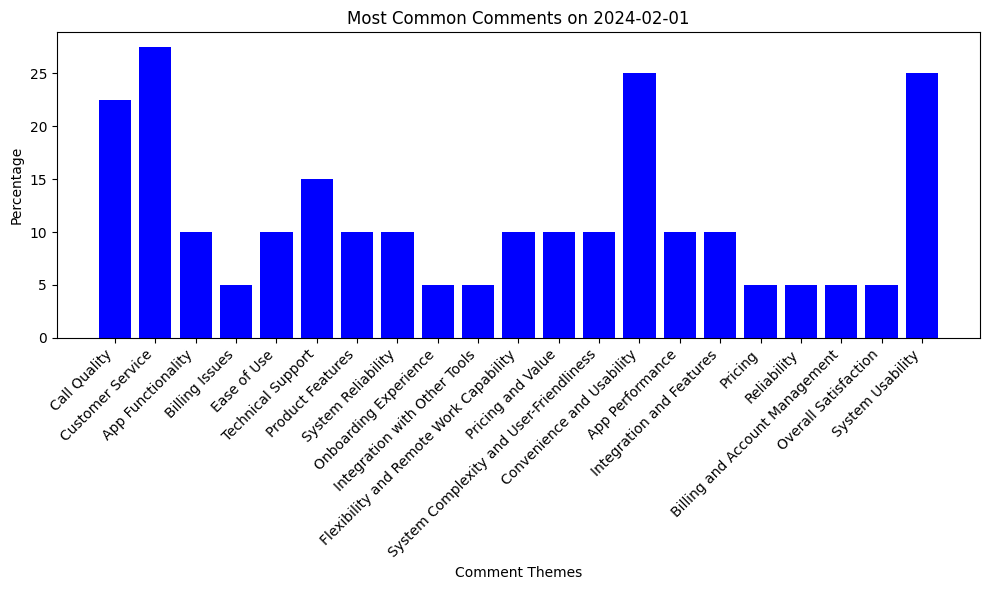

Executive Summary: The analysis of customer feedback reveals a mixed sentiment towards the product, with significant concerns in areas such as Call Quality, Customer Service, and Technical Support, which have a higher occurrence of negative comments. Positive feedback is observed in themes like Ease of Use, Flexibility, and Remote Work Capability. However, there are notable areas for improvement, including Billing Issues, System Reliability, and Onboarding Experience. Customers also express dissatisfaction with System Complexity and User-Friendliness, indicating a need for a more intuitive user experience. Despite some positive remarks on Pricing and Value, there are calls for a more streamlined, reliable, and user-friendly system. Overall, while there are areas of satisfaction, the sentiment leans towards the negative, highlighting the need for improved call quality, customer service, and system usability.


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) #Setting the figure size in inches

# Extracting data for plotting
date = json_data["date"]
theme_weights = json_data["theme_weights"]

themes = list(theme_weights.keys())
percentages = [float(weight[0][:-1]) for weight in theme_weights.values()]

# Plotting the histogram
plt.bar(themes, percentages, color='blue')
plt.xticks(rotation=45, ha='right') #Rotating and aligning the x-axis labels
plt.xlabel('Comment Themes')
plt.ylabel('Percentage')
plt.title(f'Most Common Comments on {date}')
plt.tight_layout()  # Adjusts the layout
plt.savefig('bar_plot.png', dpi=300)  # saves the plot as 'bar_plot.png' with the specified dpi
plt.show()

print(f"Executive Summary: {json_data['Summary']}")



## Plotting the Positive and Negative comments for each Topic

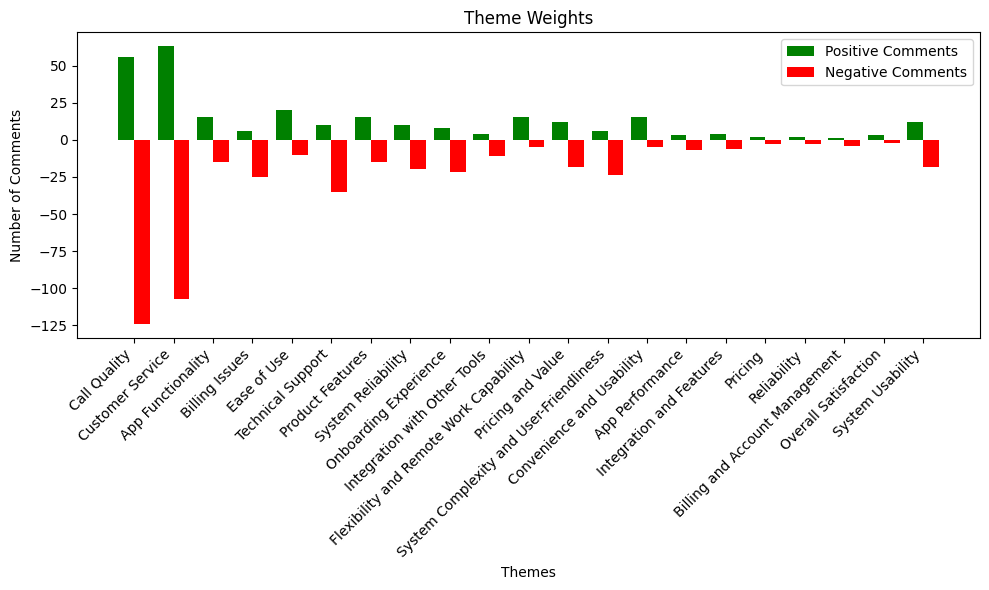

In [12]:
import numpy as np

# Extracting data for plotting
themes = list(theme_weights.keys())
positive_comments = [weight[1] for weight in theme_weights.values()]
negative_comments = [-weight[2] for weight in theme_weights.values()]

pos = np.arange(len(themes))
width = 0.4

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(pos - width/2, positive_comments, width, color='green', label='Positive Comments')
plt.bar(pos + width/2, negative_comments, width, color='red', label='Negative Comments')
plt.xticks(pos, themes, rotation=45, ha='right')
plt.xlabel('Themes')
plt.ylabel('Number of Comments')
plt.title('Theme Weights')
plt.legend()

plt.tight_layout()  # Adjusts the layout
plt.savefig('comment_distribution.png', dpi=300)  # saves the plot as 'theme_weights.png' with a resolution of 300 dpi
plt.show()

## Plotting Weights of Sub-Topics for Each Major Theme

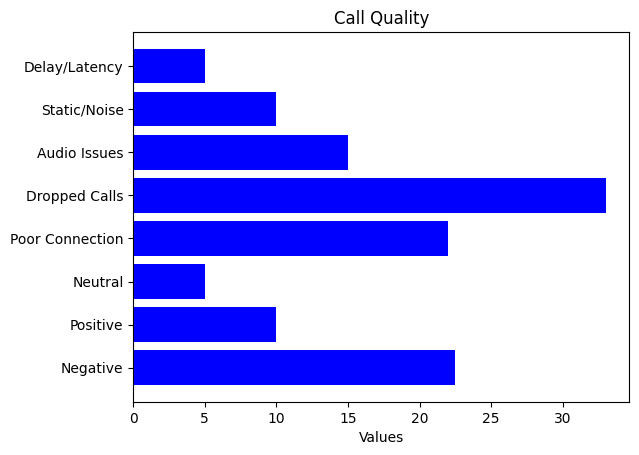

In [25]:

# Convert the data into a suitable format
subtopic_name = 'Call Quality'  #We can change the subtopic name here to get the subtopics for that theme.

# Extracting the subtopic data for a specific theme
subtopic_data = theme_json_data['theme_weights'][subtopic_name] 

categories = {}
for i in range(0, len(subtopic_data), 2):
    category = subtopic_data[i]
    value = subtopic_data[i+1]
    if isinstance(value, str) and '%' in value:  # Check if value is a percentage
        value = float(value.replace('%', ''))  # Remove '%' and convert to float
    else:
        value = float(value)  # Convert to float
    categories[category] = value

labels = list(categories.keys())
values = list(categories.values())

plt.barh(labels, values, color='blue')
plt.xlabel('Values')
plt.title(subtopic_name)
plt.show()

## Comparing with previous data stored as JSON.

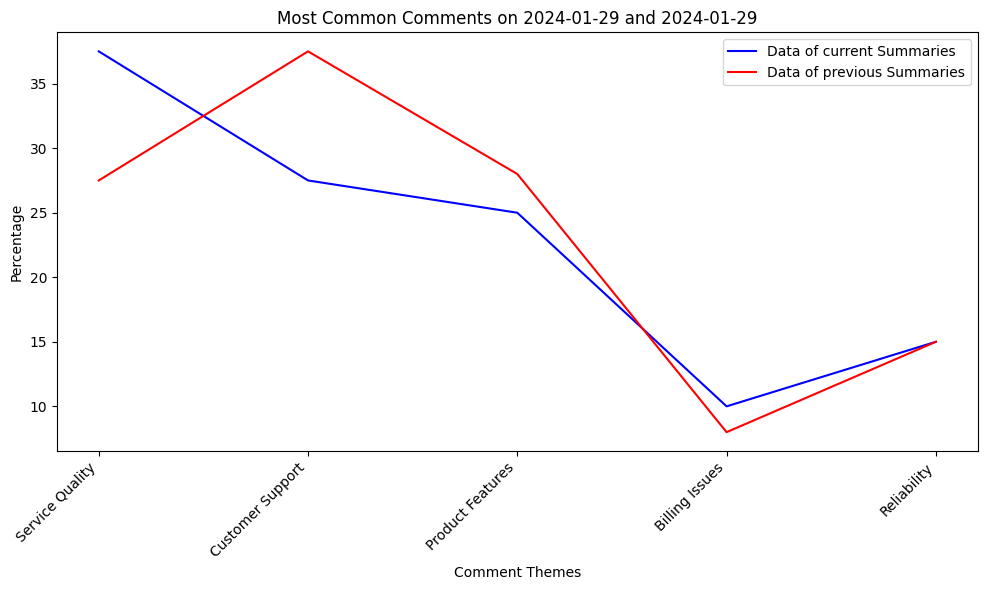

In [59]:
#Comparing json_data with the previous data

#Reading data from JSON file
with open('analysis_2023-04-14.json') as json_file: #We can change the file name here to the file we wish to compare the data with.
    old_data = json.load(json_file)

#Extracting data for plotting
old_date = old_data["date"]
old_theme_weights = old_data["theme_weights"]

old_themes = list(old_theme_weights.keys())
old_percentages = [float(weight[0][:-1]) for weight in old_theme_weights.values()]

#comparison of the data
plt.figure(figsize=(10, 6)) #Setting the figure size in inches
plt.plot(themes, percentages,label='Data of current Summaries', color='blue')
plt.plot(old_themes, old_percentages, label='Data of previous Summaries', color='red') #new percentages
plt.xticks(rotation=45, ha='right') #Rotating and aligning the x-axis labels
plt.xlabel('Comment Themes')
plt.ylabel('Percentage')
plt.title(f'Most Common Comments on {date} and {old_date}')
plt.legend()
plt.tight_layout()  # Adjusts the layout
plt.show()

# Pandas-AI experimentation

In [26]:
import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm import AzureOpenAI

llm = AzureOpenAI(
    api_token=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version="2023-05-15",
    deployment_name="gpt-4-1106-preview"
)

df = SmartDataframe("survey.csv", config={'llm': llm}) #Loading the survey data here

## Can ask specific question to the data
For more granularity we can ask exact question about the data using PandasAI. Some Exmple queries are: -
1. Give me the number of non-english speakers in the surver
2. Give me a pie chart of the distribution of languages customers speak in the survey data with a clear legend
3. How many customers were present in the survey.

In [27]:
response = df.chat("How many people speak French in the Survey?") #We can change the question here to the one we want to ask.
print(response)

22
